# CCE Moorings - Temporal Scales Analysis for Along and Cross-shelf Velocity

**Purpose**: Code for computing the mean autocorrelation function for scalar fields from CCE moorings.

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook: 

In [1]:
%matplotlib inline

Import python libraries

In [30]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
from netCDF4 import Dataset, num2date
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import cmocean
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from collections import defaultdict

# Set path to access python functions
ROOT = '/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/'
sys.path.append(ROOT + 'AirSeaCoupling/tools/')

#--- Other Functions ---# 
import cartopy_figs as cart
from autocorr import compute_autocorr_optimize, compute_decor_scale_optimize
from spectra import spectrum1D_frequency, spectral_slope
from lsf import unweighted_lsf, compute_amp_phase, compute_amp_phase_unc, detrend
from structure_functions import compute_structure_function

Set data analysis parameters

In [3]:
# Set processing parameters
option_mooring       = 'CCE2' # Specifies which mooring will analyzed. 
option_obs           = 'ADCP' # Specifies the observational instrumentation to process. Options include: 'CTD', 'CHL', 'ADCP'
option_grid          = 0      # Specifies whether the gridded product or the nearest neighbor depth-correct approach approach is used
option_plot          = 0 

# Set time and space parameters
T               = 1*(60)*(60)                         # Spcifies the time interval for model run. Units: seconds
estimator       = 'biased'                            # Specifies the approach for estimating the autocorrelation function  
start_time      = datetime(2014, 1, 1, 0, 0, 0)       # Specifies the start time of the event period  datetime(2016, 1, 1, 0, 0, 0) datetime(2025, 3, 12, 0, 0, 0)
end_time        = datetime(2015, 12, 31, 23, 59, 59)  # Specifies the end time of the event period        datetime(2025, 12, 31, 23, 59, 59)  datetime(2025, 6, 23, 0, 0, 0) 
event_time_bnds = [start_time, end_time]              # Specifies the event period

# Set path to project directory
PATH = "/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling"
PATH_bathy  = ROOT + 'AirSeaCoupling/data/bathymetry/'

# Set plotting parameters 
fontsize = 14

Load CCE processed data

In [4]:
# Set the file name and read in the data file
if option_grid == 1:
    filename_CCE = PATH + "/data/CCE/" + option_mooring + "/" + option_obs + "/" + option_mooring + "_" + option_obs + "_" + str(start_time.year) + str(start_time.month) + str(start_time.day) +  "-" + str(end_time.year) + str(end_time.month) + str(end_time.day) + "_intermediate_gridded_data.nc"
else:
    filename_CCE = PATH + "/data/CCE/" + option_mooring + "/" + option_obs + "/" + option_mooring + "_" + option_obs + "_" + str(start_time.year) + str(start_time.month) + str(start_time.day) +  "-" + str(end_time.year) + str(end_time.month) + str(end_time.day) + "_intermediate_data.nc"
nc_CCE = Dataset(filename_CCE, 'r')

# Extract data variables
depth           = nc_CCE.variables['depth'][:]
time            = num2date(nc_CCE.variables['time'][:], nc_CCE.variables['time'].units)
time_daily      = num2date(nc_CCE.variables['time_daily'][:], nc_CCE.variables['time_daily'].units)
lon             = nc_CCE.variables['LON'][:]
lat             = nc_CCE.variables['LAT'][:]

U               = nc_CCE.variables['U'][:]
V               = nc_CCE.variables['V'][:]
U_depth         = nc_CCE.variables['U_depth'][:]
V_depth         = nc_CCE.variables['V_depth'][:]
U_daily         = nc_CCE.variables['U_daily'][:]
V_daily         = nc_CCE.variables['V_daily'][:]

U_shelf               = nc_CCE.variables['U_shelf'][:]
V_shelf               = nc_CCE.variables['V_shelf'][:]
U_shelf_depth         = nc_CCE.variables['U_shelf_depth'][:]
V_shelf_depth         = nc_CCE.variables['V_shelf_depth'][:]
U_shelf_daily         = nc_CCE.variables['U_shelf_daily'][:]
V_shelf_daily         = nc_CCE.variables['V_shelf_daily'][:]

# Convert cftime.DatetimeGregorian to Python datetime objects
time_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time])
time_daily_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time_daily])

Bin average data over 12-hour windows 

In [5]:
# Set bin window length and convert to seconds
bin_hours = 12
bin_seconds = bin_hours * 3600

# Set the time elapsed from t0
t0 = time[0]
time_elapsed_hours = np.array([(t - t0).total_seconds() for t in time])

# Assign time steps to bins
bin_index = np.floor(time_elapsed_hours / bin_seconds).astype(int)
unique_bins = np.unique(bin_index)

# Bin-average time
time_bin = np.array([np.mean(time_elapsed_hours[bin_index == b]) for b in unique_bins])

# Convert back to datetme
time_tmp = np.array([t0 + timedelta(seconds=s) for s in time_bin])
time_bin_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time_tmp])

#--- Depth averages velocity components ---# 

def masked_bin_average(data, bin_index, unique_bins):
    vals = []
    mask = []
    for b in unique_bins:
        d = data[bin_index == b]
        if np.ma.is_masked(d) and d.mask.all():
            vals.append(0.0)     # Dummy value
            mask.append(True)
        else:
            vals.append(np.ma.mean(d))
            mask.append(False)
    return np.ma.array(vals, mask=mask)

U_depth_bin = masked_bin_average(U_depth, bin_index, unique_bins)
V_depth_bin = masked_bin_average(V_depth, bin_index, unique_bins)
U_shelf_depth_bin = masked_bin_average(U_shelf_depth, bin_index, unique_bins)
V_shelf_depth_bin = masked_bin_average(V_shelf_depth, bin_index, unique_bins)

# U_depth_bin = np.ma.array([np.ma.mean(U_depth[bin_index == b]) for b in unique_bins])
# V_depth_bin = np.ma.array([np.ma.mean(V_depth[bin_index == b]) for b in unique_bins])
# U_shelf_depth_bin = np.ma.array([np.ma.mean(U_shelf_depth[bin_index == b]) for b in unique_bins])
# V_shelf_depth_bin = np.ma.array([np.ma.mean(V_shelf_depth[bin_index == b]) for b in unique_bins])

#--- Depth dependent velocity components ---# 

# Set parameters
ndepth,_ = np.shape(U)
ntime = len(time_bin)

# Initialize arrays
U_bin = np.ma.masked_all((ndepth,ntime))
V_bin = np.ma.masked_all((ndepth,ntime))
U_shelf_bin = np.ma.masked_all((ndepth,ntime))
V_shelf_bin = np.ma.masked_all((ndepth,ntime))

# Loop through depths
for idepth in range(0,ndepth):

    # Bin-average the velocity components 
    U_bin[idepth,:] = np.ma.array([np.ma.mean(U[idepth,bin_index == b]) for b in unique_bins])
    V_bin[idepth,:] = np.ma.array([np.ma.mean(V[idepth,bin_index == b]) for b in unique_bins])
    U_shelf_bin[idepth,:] = np.ma.array([np.ma.mean(U[idepth,bin_index == b]) for b in unique_bins])
    V_shelf_bin[idepth,:] = np.ma.array([np.ma.mean(V[idepth,bin_index == b]) for b in unique_bins])

/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


Compute the kinetic energy 

In [6]:
#--- Depth and time dependent Kinetic Energy ---#

# Compute temporal mean at each depth
u_mean = np.mean(U, axis=0)   # shape (depth,)
v_mean = np.mean(V, axis=0)

# Compute MKE at each depth (scalar per depth)
MKE = 0.5 * (u_mean**2 + v_mean**2)  # shape (depth,)

# Compute perturbations
u_prime = U - u_mean  # shape (time, depth)
v_prime = V - v_mean

# Compute EKE time series at each depth
EKE = 0.5 * (u_prime**2 + v_prime**2)  # shape (time, depth)

# Compute time-averaged EKE at each depth
EKE_mean = np.mean(EKE, axis=0)  # shape (depth,)

# Compute the total KE
KE_tot     = 0.5 * (U**2 + V**2)
KE_tot_mean = np.mean(KE_tot, axis=0)

#--- Depth and 12-hourly Kinetic Energy ---#

# Compute temporal mean at each depth
u_mean = np.mean(U_bin, axis=0)   # shape (depth,)
v_mean = np.mean(V_bin, axis=0)

# Compute MKE at each depth (scalar per depth)
MKE_bin = 0.5 * (u_mean**2 + v_mean**2)  # shape (depth,)

# Compute perturbations
u_prime = U_bin - u_mean  # shape (time, depth)
v_prime = V_bin - v_mean

# Compute EKE time series at each depth
EKE_bin = 0.5 * (u_prime**2 + v_prime**2)  # shape (time, depth)

# Compute time-averaged EKE at each depth
EKE_bin_mean = np.mean(EKE, axis=0)  # shape (depth,)

# Compute the total KE
KE_tot_bin     = 0.5 * (U**2 + V**2)
KE_tot_bin_mean = np.mean(KE_tot, axis=0)

#--- Depth-Averaged 12-hourly Kinetic Energy ---#

# Compute temporal mean 
u_mean = np.mean(U_depth_bin)
v_mean = np.mean(V_depth_bin)

# Compute the MKE
MKE_depth_bin = 0.5 * (u_mean**2 + v_mean**2)

# Eddy components
u_prime = U_depth_bin - u_mean
v_prime = V_depth_bin - v_mean

# EKE time series
EKE_depth_bin = 0.5 * (u_prime**2 + v_prime**2)

# Time-averaged EKE
EKE_depth_bin_mean = np.mean(EKE_depth_bin)

# Compute the total KE
KE_tot_depth_bin      = 0.5 * (U_depth_bin**2 + V_depth_bin**2)
KE_tot_depth_bin_mean = np.mean(KE_tot_depth_bin, axis=0)

#--- Depth-Averaged daily Kinetic Energy ---#

# Compute temporal mean 
u_mean = np.mean(U_daily)
v_mean = np.mean(V_daily)

# Compute the MKE
MKE_depth = 0.5 * (u_mean**2 + v_mean**2)

# Eddy components
u_prime = U_daily - u_mean
v_prime = V_daily - v_mean

# EKE time series
EKE_depth = 0.5 * (u_prime**2 + v_prime**2)

# Time-averaged EKE
EKE_depth_mean = np.mean(EKE_depth)

# Compute the total KE
KE_tot_depth      = 0.5 * (U_daily**2 + V_daily**2)
KE_tot_depth_mean = np.mean(KE_tot_depth, axis=0)

Plot the kinetic energy 

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_51340/1351605624.py:103: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax4.set_ylim([0, 0.1])


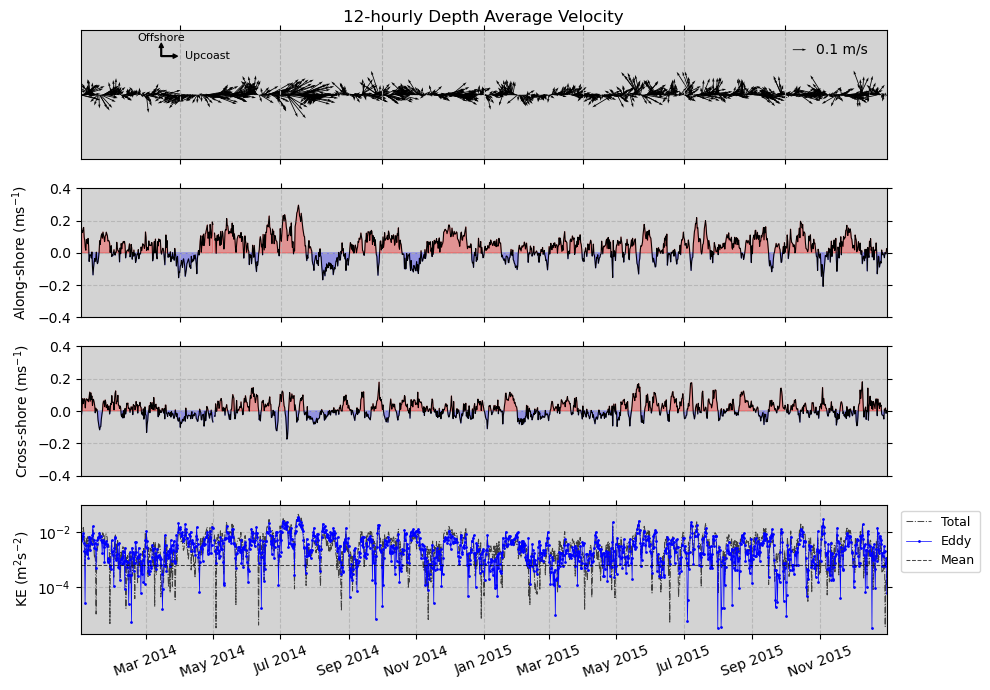

In [7]:
# Create figure
fig, axes = plt.subplots(4,1,figsize=(10, 7))
ax1,ax2,ax3,ax4 = axes.flatten()

#--- Subplot 1 ---# 

# Plot the velocity vectors
q = ax1.quiver(time_bin_dt, np.zeros_like(time_bin_dt), U_shelf_depth_bin, V_shelf_depth_bin, scale=6, width=0.001)

# Set axis attributes
ax1.set_title("12-hourly Depth Average Velocity")
ax1.set_xlim([time_bin_dt[0], time_bin_dt[-1]])
ax1.set_xticklabels([])
ax1.set_yticks([])
ax1.tick_params(top=True, bottom=True, left=False, right=False,
            direction='out', length=3.5)
ax1.grid(True, linestyle='--')

# Add coordinate system arrows in top subplot
arrow_length_x,arrow_length_y = 0.02, 0.1  # adjust based on scale of your plot
x0, y0 = 0.1, 0.8    # location in axis coordinates (0–1)

# Add arrows using annotation in axis coordinates
ax1.annotate('', xy=(x0 + arrow_length_x, y0), xytext=(x0, y0),
            xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(facecolor='black', width=0.5, headwidth=3, headlength=3))
ax1.text(x0 + arrow_length_x + 0.01, y0, 'Upcoast', transform=ax1.transAxes,
        verticalalignment='center', fontsize=8)

ax1.annotate('', xy=(x0, y0 + arrow_length_y), xytext=(x0, y0),
            xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(facecolor='black', width=0.5, headwidth=3, headlength=3))
ax1.text(x0, y0 + arrow_length_y + 0.02, 'Offshore', transform=ax1.transAxes,
        horizontalalignment='center', fontsize=8)

# Set quiver legend
ax1.quiverkey(q, X=0.9, Y=0.85, U=0.1, label='0.1 m/s', labelpos='E', coordinates='axes')

# Set the background color of the axes
ax1.set_facecolor('lightgray')

#--- Subplot 2 ---#  

# Plot black lines with different linestyles
ax2.plot(time_bin_dt, U_shelf_depth_bin, '-', label="Along-shore", color='black', linewidth=0.75, markersize=2)

# Shading: Along-shore
ax2.fill_between(time_bin_dt, U_shelf_depth_bin, 0,
                 where=(U_shelf_depth_bin > 0), interpolate=True, color='red', alpha=0.3)
ax2.fill_between(time_bin_dt, U_shelf_depth_bin, 0,
                 where=(U_shelf_depth_bin < 0), interpolate=True, color='blue', alpha=0.3)

# Set legend
#ax2.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

# Set axis attributes
ax2.set_ylabel("Along-shore (ms$^{-1}$)")
ax2.set_xlim(time[0], time[-1])
ax2.set_xticklabels([])
ax2.set_ylim([-0.4, 0.4])
ax2.tick_params(top=True, bottom=True, left=True, right=True,
                direction='out', length=3.5)
ax2.grid(True, linestyle='--', alpha=0.8)
ax2.set_facecolor('lightgray')

#--- Subplot 3 ---# 

# Plot black lines with different linestyles
ax3.plot(time_bin_dt, V_shelf_depth_bin, '-', label="Cross-shore", color='black', linewidth=0.75, markersize=2)

# Shading: Cross-shore
ax3.fill_between(time_bin_dt, V_shelf_depth_bin, 0,
                 where=(V_shelf_depth_bin > 0), interpolate=True, color='red', alpha=0.3)
ax3.fill_between(time_bin_dt, V_shelf_depth_bin, 0,
                 where=(V_shelf_depth_bin < 0), interpolate=True, color='blue', alpha=0.3)

# Set legend
#ax2.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

# Set axis attributes
ax3.set_ylabel("Cross-shore (ms$^{-1}$)")
ax3.set_xlim(time[0], time[-1])
ax3.set_xticklabels([])
ax3.set_ylim([-0.4, 0.4])
ax3.tick_params(top=True, bottom=True, left=True, right=True,
                direction='out', length=3.5)
ax3.grid(True, linestyle='--', alpha=0.8)
ax3.set_facecolor('lightgray')

#--- Subplot 4 ---#  

# Plot depth and daily average along- and cross-shore components
ax4.semilogy(time_bin_dt, KE_tot_depth_bin, '-.', label="Total", color='k', linewidth=0.75, markersize=2, alpha = 0.7)
ax4.semilogy(time_bin_dt, EKE_depth_bin, '.-', label="Eddy", color='blue', linewidth=0.5, markersize=2)
ax4.axhline(MKE_depth_bin, linestyle='--' ,label="Mean",color='k', linewidth=0.75,alpha=0.7)
 
# Set legend
ax4.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

# Set axis attributes
ax4.set_ylabel("KE (m$^2$s$^{-2}$)")
ax4.set_xlim(time_bin_dt[0], time_bin_dt[-1])
ax4.set_ylim([0, 0.1])
ax4.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax4.get_xticklabels(), rotation=20)
ax4.tick_params(top=True, bottom=True, left=True, right=True,
            direction='out', length=3.5)
ax4.grid(True, linestyle='--', alpha=0.8)

# Set the background color of the axes
ax4.set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

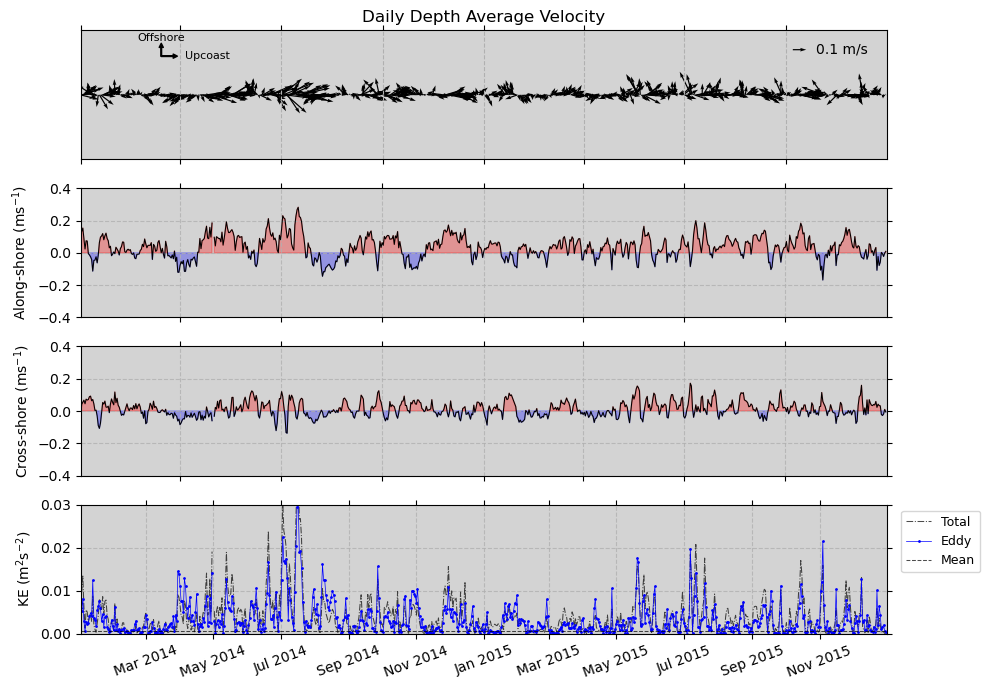

In [11]:
# Create figure
fig, axes = plt.subplots(4,1,figsize=(10, 7))
ax1,ax2,ax3,ax4 = axes.flatten()

#--- Subplot 1 ---# 

# Plot the velocity vectors
q = ax1.quiver(time_daily_dt, np.zeros_like(time_daily_dt), U_shelf_daily, V_shelf_daily, scale=6, width=0.0015)

# Set axis attributes
ax1.set_title("Daily Depth Average Velocity")
ax1.set_xlim([time_daily_dt[0], time_daily_dt[-1]])
ax1.set_xticklabels([])
ax1.set_yticks([])
ax1.tick_params(top=True, bottom=True, left=False, right=False,
            direction='out', length=3.5)
ax1.grid(True, linestyle='--')

# Add coordinate system arrows in top subplot
arrow_length_x,arrow_length_y = 0.02, 0.1  # adjust based on scale of your plot
x0, y0 = 0.1, 0.8    # location in axis coordinates (0–1)

# Add arrows using annotation in axis coordinates
ax1.annotate('', xy=(x0 + arrow_length_x, y0), xytext=(x0, y0),
            xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(facecolor='black', width=0.5, headwidth=3, headlength=3))
ax1.text(x0 + arrow_length_x + 0.01, y0, 'Upcoast', transform=ax1.transAxes,
        verticalalignment='center', fontsize=8)

ax1.annotate('', xy=(x0, y0 + arrow_length_y), xytext=(x0, y0),
            xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(facecolor='black', width=0.5, headwidth=3, headlength=3))
ax1.text(x0, y0 + arrow_length_y + 0.02, 'Offshore', transform=ax1.transAxes,
        horizontalalignment='center', fontsize=8)

# Set quiver legend
ax1.quiverkey(q, X=0.9, Y=0.85, U=0.1, label='0.1 m/s', labelpos='E', coordinates='axes')

# Set the background color of the axes
ax1.set_facecolor('lightgray')

#--- Subplot 2 ---#  

# Plot black lines with different linestyles
ax2.plot(time_daily_dt, U_shelf_daily, '-', label="Along-shore", color='black', linewidth=0.75, markersize=2)

# Shading: Along-shore
ax2.fill_between(time_daily_dt, U_shelf_daily, 0,
                 where=(U_shelf_daily > 0), interpolate=True, color='red', alpha=0.3)
ax2.fill_between(time_daily_dt, U_shelf_daily, 0,
                 where=(U_shelf_daily < 0), interpolate=True, color='blue', alpha=0.3)

# Set legend
#ax2.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

# Set axis attributes
ax2.set_ylabel("Along-shore (ms$^{-1}$)")
ax2.set_xlim(time[0], time[-1])
ax2.set_xticklabels([])
ax2.set_ylim([-0.4, 0.4])
ax2.tick_params(top=True, bottom=True, left=True, right=True,
                direction='out', length=3.5)
ax2.grid(True, linestyle='--', alpha=0.8)
ax2.set_facecolor('lightgray')

#--- Subplot 3 ---# 

# Plot black lines with different linestyles
ax3.plot(time_daily_dt, V_shelf_daily, '-', label="Cross-shore", color='black', linewidth=0.75, markersize=2)

# Shading: Cross-shore
ax3.fill_between(time_daily_dt, V_shelf_daily, 0,
                 where=(V_shelf_daily > 0), interpolate=True, color='red', alpha=0.3)
ax3.fill_between(time_daily_dt, V_shelf_daily, 0,
                 where=(V_shelf_daily < 0), interpolate=True, color='blue', alpha=0.3)

# Set legend
#ax2.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

# Set axis attributes
ax3.set_ylabel("Cross-shore (ms$^{-1}$)")
ax3.set_xlim(time[0], time[-1])
ax3.set_xticklabels([])
ax3.set_ylim([-0.4, 0.4])
ax3.tick_params(top=True, bottom=True, left=True, right=True,
                direction='out', length=3.5)
ax3.grid(True, linestyle='--', alpha=0.8)
ax3.set_facecolor('lightgray')

#--- Subplot 4 ---#  

# Plot depth and daily average along- and cross-shore components
ax4.plot(time_daily_dt, KE_tot_depth, '-.', label="Total", color='k', linewidth=0.75, markersize=2, alpha = 0.7)
ax4.plot(time_daily_dt, EKE_depth, '.-', label="Eddy", color='blue', linewidth=0.5, markersize=2)
ax4.axhline(MKE_depth, linestyle='--' ,label="Mean",color='k', linewidth=0.75,alpha=0.7)
 
# Set legend
ax4.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

# Set axis attributes
ax4.set_ylabel("KE (m$^2$s$^{-2}$)")
ax4.set_xlim(time[0], time[-1])
ax4.set_ylim([0, 0.03])
ax4.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax4.get_xticklabels(), rotation=20)
ax4.tick_params(top=True, bottom=True, left=True, right=True,
            direction='out', length=3.5)
ax4.grid(True, linestyle='--', alpha=0.8)

# Set the background color of the axes
ax4.set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

Preform scale analysis

In [12]:
# Set parameters
ndepth,ntime = np.shape(U_shelf_bin)
lag = ntime
w1, w2 = [(2*np.pi)/31557600, (1/2)*(2*np.pi)/31557600]      # Radian Frequency for annual and semi-annual cycles. Units: rad/sec
M = 20                                                       # Specifies number of windows to divide the data into for the Welch method
p = ntime // M                                               # Specifies window length, i.e., number of data points in each segment
nfft = (p // 2 + 1) if (p % 2 == 0) else ((p - 1) // 2)      # Specifies number of positive frequency bins in the resulting power spectrum
units = 'Hz'

# Define frequency range for slope fitting (sub-interial and super-inertial)
fmin_sub = 6*10**(-2) 
fmax_sub = 6*10**(-1) 
fmin_sup = 2*10**(0)
fmax_sup = 1.25*10**(1)

#--- Along-shore 12-hourly Velocity --- #

# Initialize arrays 
autocorr_u       = np.zeros((ntime,ndepth))
time_scale_u     = np.zeros((ntime,ndepth))
L_t_u            = np.zeros((ndepth))
S_u              = np.zeros((nfft,ndepth))
CI_u             = np.zeros((nfft,2,ndepth))
S_u_slope_sub    = np.zeros((ndepth))
S_u_slope_unc_sub = np.zeros((ndepth))
S_u_slope_sup    = np.zeros((ndepth))
S_u_slope_unc_sup = np.zeros((ndepth))
E_scale_u        = np.zeros((ndepth))

# Set counter
cn_depth = 0 

# Loop through depths 
for idepth in range(0,ndepth):
    
    # Try statement to handle exceptions so that errors can be passed without crashing the program
    try:
    
        # Set progress bar
        progress = (idepth) / (len(depth))
        sys.stdout.write(f"\rProgress: {progress:.1%}")
        sys.stdout.flush()
                
        # Initialize the ith time series 
        data_ts = U_shelf_bin[idepth,:]

        # Remove annual and semi-annual cycle 
        hfit, x_data, x_data_sigma, _ = unweighted_lsf(data_ts, time_bin, parameters = 2, freqs = np.array([w1,w2]), sigma = None)
        data_ts_rm = data_ts - hfit

        # Detrend data record 
        data_dt = detrend(data_ts_rm, time_bin, mean = 0)

        # Compute autocorrelation function
        autocorr_u[:,cn_depth], _, _, _, time_scale_u[:,cn_depth], _ = compute_autocorr_optimize(data_dt, time_bin, lag, estimator, 0)

        # Compute the decorrelation scale
        L_t_u[cn_depth] = compute_decor_scale_optimize(autocorr_u[:,cn_depth],time_scale_u[:,cn_depth],T,'unbiased',0)

        # Compute frequency power spectrum 
        data_interp = np.interp(time_bin, time_bin[~data_dt.mask], data_dt[~data_dt.mask])
        S_u[:,cn_depth], f_u, CI_u[:,:,cn_depth], _ = spectrum1D_frequency(data_interp, T, M, units)

        # Compute the energy-containing scales
        f_zero = f_u[f_u > 0]
        S_zero = S_u[f_u > 0,cn_depth]
        spectral_centroid = np.trapz(f_zero * S_zero, f_zero) / np.trapz(S_zero, f_zero)
        E_scale_u[cn_depth] = (1 / spectral_centroid) * (1/(60*60*24))    # Units: days

        # Compute the sub-inertial and super inertial spectral slope
        f_cpd = f_u*(60)*(60)*(24)
        S_u_slope_sub[cn_depth], S_u_slope_unc_sub[cn_depth], S_u_fit_sub, f_range_sub = spectral_slope(f_cpd, S_u[:,cn_depth], fmin_sub, fmax_sub)
        S_u_slope_sup[cn_depth], S_u_slope_unc_sup[cn_depth], S_u_fit_sup, f_range_sup = spectral_slope(f_cpd, S_u[:,cn_depth], fmin_sup, fmax_sup)

        # Plot Spectral slope 
        if option_plot == True: 
                
                plt.figure(figsize=(8, 5))
                plt.loglog(f_cpd, S_u[:,cn_depth], label='PSD')
                plt.loglog(f_range_sub, S_u_fit_sub, '--r', label=f'Fit: slope = {S_u_slope_sub[cn_depth]:.2f} ± {S_u_slope_unc_sub[cn_depth]:.2f}')
                plt.loglog(f_range_sup, S_u_fit_sup, '--b', label=f'Fit: slope = {S_u_slope_sup[cn_depth]:.2f} ± {S_u_slope_unc_sup[cn_depth]:.2f}')
                plt.xlabel('Frequency [Hz]')
                plt.ylabel('PSD')
                plt.title('Spectral Slope Test')
                plt.legend()
                plt.grid(True, which='both', ls='--')
                plt.tight_layout()
                plt.show()

        # Compute structure function
        S_i, lag_i = compute_structure_function(data_ts, lag, orders=[1, 2, 3, 4])

        # Set longitude counter
        cn_depth = cn_depth + 1

    except Exception: 

        # Print warining message 
        print('Ran into error, skipping depth!')

# Convert time scale to units of days
Lt_u = L_t_u*(1/60)*(1/60)*(1/24)

#--- Cross-shore Velocity ---# 

# Initialize arrays 
autocorr_v        = np.zeros((ntime,ndepth))
time_scale_v      = np.zeros((ntime,ndepth))
L_t_v             = np.zeros((ndepth))
S_v               = np.zeros((nfft,ndepth))
CI_v              = np.zeros((nfft,2,ndepth))
S_v_slope_sub     = np.zeros((ndepth))
S_v_slope_unc_sub = np.zeros((ndepth))
S_v_slope_sup     = np.zeros((ndepth))
S_v_slope_unc_sup = np.zeros((ndepth))
E_scale_v         = np.zeros((ndepth))

# Set counter
cn_depth = 0 

# Loop through depths 
for idepth in range(0,ndepth):
    
    # Try statement to handle exceptions so that errors can be passed without crashing the program
    try:
    
        # Set progress bar
        progress = (idepth) / (len(depth))
        sys.stdout.write(f"\rProgress: {progress:.1%}")
        sys.stdout.flush()
                
        # Initialize the ith time series 
        data_ts = V_shelf_bin[idepth,:]

        # Remove annual and semi-annual cycle 
        hfit, x_data, x_data_sigma, _ = unweighted_lsf(data_ts, time_bin, parameters = 2, freqs = np.array([w1,w2]), sigma = None)
        data_ts_rm = data_ts - hfit

        # Detrend data record 
        data_dt = detrend(data_ts_rm, time_bin, mean = 0)

        # Compute autocorrelation function
        autocorr_v[:,cn_depth], _, _, _, time_scale_v[:,cn_depth], _ = compute_autocorr_optimize(data_dt, time_bin, lag, estimator, 0)

        # Compute the decorrelation scale
        L_t_v[cn_depth] = compute_decor_scale_optimize(autocorr_v[:,cn_depth],time_scale_v[:,cn_depth],T,'unbiased',0)

        # Compute frequency power spectrum 
        data_interp = np.interp(time_bin, time_bin[~data_dt.mask], data_dt[~data_dt.mask])
        S_v[:,cn_depth], f_v, CI_v[:,:,cn_depth], _ = spectrum1D_frequency(data_interp, T, M, units)

        # Compute the energy-containing scales
        f_zero = f_v[f_v > 0]
        S_zero = S_v[f_v > 0,cn_depth]
        spectral_centroid = np.trapz(f_zero * S_zero, f_zero) / np.trapz(S_zero, f_zero)
        E_scale_v[cn_depth] = (1 / spectral_centroid) * (1/(60*60*24))    # Units: days

        # Compute the sub-inertial and super inertial spectral slope
        f_cpd = f_v*(60)*(60)*(24)
        S_v_slope_sub[cn_depth], S_v_slope_unc_sub[cn_depth], S_v_fit_sub, f_range_sub = spectral_slope(f_cpd, S_v[:,cn_depth], fmin_sub, fmax_sub)
        S_v_slope_sup[cn_depth], S_v_slope_unc_sup[cn_depth], S_v_fit_sup, f_range_sup = spectral_slope(f_cpd, S_v[:,cn_depth], fmin_sup, fmax_sup)

        # Compute structure function
        #S_i, lag_i = compute_structure_function(data_m, lag, orders=[1, 2, 3, 4])

        # Set longitude counter
        cn_depth = cn_depth + 1

    except Exception: 

        # Print warining message 
        print('Ran into error, skipping depth!')

# Convert time scale to units of days
Lt_v = L_t_v*(1/60)*(1/60)*(1/24)

#--- EKE ---# 

# Initialize arrays 
autocorr_eke       = np.zeros((ntime,ndepth))
time_scale_eke     = np.zeros((ntime,ndepth))
L_t_eke            = np.zeros((ndepth))
S_eke              = np.zeros((nfft,ndepth))
CI_eke             = np.zeros((nfft,2,ndepth))
S_eke_slope_sub    = np.zeros((ndepth))
S_eke_slope_unc_sub = np.zeros((ndepth))
S_eke_slope_sup    = np.zeros((ndepth))
S_eke_slope_unc_sup = np.zeros((ndepth))
E_scale_eke        = np.zeros((ndepth))

# Set counter
cn_depth = 0 

# Loop through depths 
for idepth in range(0,ndepth):
    
    # Try statement to handle exceptions so that errors can be passed without crashing the program
    try:
    
        # Set progress bar
        progress = (idepth) / (len(depth))
        sys.stdout.write(f"\rProgress: {progress:.1%}")
        sys.stdout.flush()
                
        # Initialize the ith time series 
        data_ts = EKE_bin[idepth,:]

        # Remove annual and semi-annual cycle 
        hfit, x_data, x_data_sigma, _ = unweighted_lsf(data_ts, time_bin, parameters = 2, freqs = np.array([w1,w2]), sigma = None)
        data_ts_rm = data_ts - hfit

        # Detrend data record 
        data_dt = detrend(data_ts_rm, time_bin, mean = 0)

        # Compute autocorrelation function
        autocorr_eke[:,cn_depth], _, _, _, time_scale_eke[:,cn_depth], _ = compute_autocorr_optimize(data_dt, time_bin, lag, estimator, 0)

        # Compute the decorrelation scale
        L_t_eke[cn_depth] = compute_decor_scale_optimize(autocorr_eke[:,cn_depth],time_scale_eke[:,cn_depth],T,'unbiased',0)

        # Compute frequency power spectrum 
        data_interp = np.interp(time_bin, time_bin[~data_dt.mask], data_dt[~data_dt.mask])
        S_eke[:,cn_depth], f_eke, CI_eke[:,:,cn_depth], _ = spectrum1D_frequency(data_interp, T, M, units)

        # Compute the energy-containing scales
        f_zero = f_eke[f_eke > 0]
        S_zero = S_eke[f_eke > 0,cn_depth]
        spectral_centroid = np.trapz(f_zero * S_zero, f_zero) / np.trapz(S_zero, f_zero)
        E_scale_eke[cn_depth] = (1 / spectral_centroid) * (1/(60*60*24))    # Units: days

        # Compute the sub-inertial and super inertial spectral slope
        f_cpd = f_eke*(60)*(60)*(24)
        S_eke_slope_sub[cn_depth], S_eke_slope_unc_sub[cn_depth], S_eke_fit_sub, f_range_sub = spectral_slope(f_cpd, S_eke[:,cn_depth], fmin_sub, fmax_sub)
        S_eke_slope_sup[cn_depth], S_eke_slope_unc_sup[cn_depth], S_eke_fit_sup, f_range_sup = spectral_slope(f_cpd, S_eke[:,cn_depth], fmin_sup, fmax_sup)

        # Compute structure function
        #S_i, lag_i = compute_structure_function(data_m, lag, orders=[1, 2, 3, 4])

        # Set longitude counter
        cn_depth = cn_depth + 1

    except Exception: 

        # Print warining message 
        print('Ran into error, skipping depth!')  

# Convert time scale to units of days
Lt_eke = L_t_eke*(1/60)*(1/60)*(1/24)

Progress: 1.8%

/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Progress: 98.2%

Compute the decorrelation scale of the depth averaged velocity and EKE

In [ ]:
# Set parameters
ntime = len(U_shelf_depth_bin)
lag = ntime
w1, w2 = [(2*np.pi)/31557600, (1/2)*(2*np.pi)/31557600]      # Radian Frequency for annual and semi-annual cycles. Units: rad/sec
M = 20                                                       # Specifies number of windows to divide the data into for the Welch method
p = ntime // M                                               # Specifies window length, i.e., number of data points in each segment
nfft = (p // 2 + 1) if (p % 2 == 0) else ((p - 1) // 2)      # Specifies number of positive frequency bins in the resulting power spectrum
units = 'Hz'
option_plot = 1

# Compute the interial period in units of cpd
omega = (7.2921*10**(-5))/(2*np.pi)                   # Units: Hz 
f_inertial = 2*omega*np.sin(np.deg2rad(lat))*(86400)  # Units: cpd

#----------------------------------------------------#
#------------- Along-shore Velocity -----------------#
#----------------------------------------------------#

# Initialize the independent and dependent variables
data_ts = U_shelf_depth_bin
time_n = time_bin

# Remove annual and semi-annual cycle 
hfit, x_data, x_data_sigma, _ = unweighted_lsf(data_ts, time_n, parameters = 2, freqs = np.array([w1,w2]), sigma = None)
data_ts_rm = data_ts - hfit

# Detrend data record 
data_dt = detrend(data_ts_rm, time_n, mean = 0)

# Compute autocorrelation function
autocorr_ud, _, _, _, time_scale_ud, _ = compute_autocorr_optimize(data_dt, time_n, lag, estimator, 0)

# Compute the decorrelation scale
L_t_ud = compute_decor_scale_optimize(autocorr_ud,time_scale_ud,T,'unbiased',0)

# Compute frequency power spectrum 
data_interp = np.interp(time_n, time_n[~data_dt.mask], data_dt[~data_dt.mask])
S_ud, f_ud, CI_ud, _ = spectrum1D_frequency(data_interp, T, M, units)

# Compute the energy-containing scales
f_zero = f_ud[f_ud > 0]
S_zero = S_ud[f_ud > 0]
spectral_centroid = np.trapz(f_zero * S_zero, f_zero) / np.trapz(S_zero, f_zero)
E_scale_ud = (1 / spectral_centroid) * (1/(60*60*24))    # Units: days

# Compute the sub-inertial and super inertial spectral slope
f_cpd = f_ud*(60)*(60)*(24)
S_ud_slope_sub, S_ud_slope_unc_sub, S_ud_fit_sub, f_range_sub = spectral_slope(f_cpd, S_ud, fmin_sub, fmax_sub)
S_ud_slope_sup, S_ud_slope_unc_sup, S_ud_fit_sup, f_range_sup = spectral_slope(f_cpd, S_ud, fmin_sup, fmax_sup)

# Compute structure function
data_interp = np.interp(time_n, time_n[~data_dt.mask], data_dt[~data_ts.mask])
struct_ud, lag_ud = compute_structure_function(data_interp, lag, orders=[1, 2, 3, 4])

# Set longitude counter
cn_depth = cn_depth + 1

# Convert time scale to units of days
Lt_ud = L_t_ud*(1/60)*(1/60)*(1/24)

#----------------------------------------------------#
#------------- Cross-shore Velocity -----------------#
#----------------------------------------------------#

# Initialize the ith time series 
data_ts = V_shelf_depth_bin

# Remove annual and semi-annual cycle 
hfit, x_data, x_data_sigma, _ = unweighted_lsf(data_ts, time_n, parameters = 2, freqs = np.array([w1,w2]), sigma = None)
data_ts_rm = data_ts - hfit

# Detrend data record 
data_dt = detrend(data_ts_rm, time_n, mean = 0)

# Compute autocorrelation function
autocorr_vd, _, _, _, time_scale_vd, _ = compute_autocorr_optimize(data_dt, time_n, lag, estimator, 0)

# Compute the decorrelation scale
L_t_vd = compute_decor_scale_optimize(autocorr_vd,time_scale_vd,T,'unbiased',0)

# Compute frequency power spectrum 
data_interp = np.interp(time_n, time_n[~data_dt.mask], data_dt[~data_dt.mask])
S_vd, f_vd, CI_vd, _ = spectrum1D_frequency(data_interp, T, M, units)

# Compute the energy-containing scales
f_zero = f_vd[f_vd > 0]
S_zero = S_vd[f_vd > 0]
spectral_centroid = np.trapz(f_zero * S_zero, f_zero) / np.trapz(S_zero, f_zero)
E_scale_vd = (1 / spectral_centroid) * (1/(60*60*24))    # Units: days

# Compute the sub-inertial and super inertial spectral slope
f_cpd = f_vd*(60)*(60)*(24)
S_vd_slope_sub, S_vd_slope_unc_sub, S_vd_fit_sub, f_range_sub = spectral_slope(f_cpd, S_vd, fmin_sub, fmax_sub)
S_vd_slope_sup, S_vd_slope_unc_sup, S_vd_fit_sup, f_range_sup = spectral_slope(f_cpd, S_vd, fmin_sup, fmax_sup)

# Compute structure function
data_interp = np.interp(time_n, time_n[~data_ts.mask], data_ts[~data_ts.mask])
struct_vd, lag_vd = compute_structure_function(data_interp, lag, orders=[1, 2, 3, 4])

# Set longitude counter
cn_depth = cn_depth + 1

# Convert time scale to units of days
Lt_vd = L_t_vd*(1/60)*(1/60)*(1/24)

/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Plot a comparison of the decorrelation scales from each of the variables

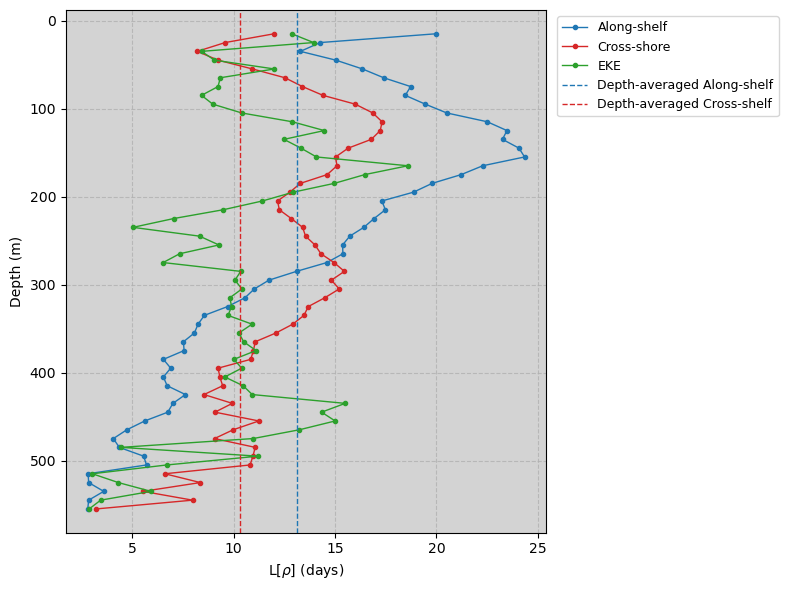

In [14]:
# Create the figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Plot the depth-dependent decorrelation time scale
ax.plot(Lt_u, depth, '.-', color='tab:blue', linewidth=1,label='Along-shelf')
ax.plot(Lt_v, depth, '.-', color='tab:red', linewidth=1, label='Cross-shore')
ax.plot(Lt_eke, depth, '.-', color='tab:green', linewidth=1, label='EKE')

# Plot decorrelation time scale from depth averaged velocity
ax.axvline(Lt_ud,linestyle='--',color='tab:blue',linewidth=1,label='Depth-averaged Along-shelf')
ax.axvline(Lt_vd,linestyle='--',color='tab:red',linewidth=1,label='Depth-averaged Cross-shelf')

# Set figure attributes
ax.set_xlabel(r'L[$\rho$] (days)')
ax.set_ylabel('Depth (m)')
ax.grid(True,linestyle='--',alpha=0.8)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

# Reverse the direction of the x-axis 
ax.invert_yaxis() 

# Set the background color of the axes
ax.set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

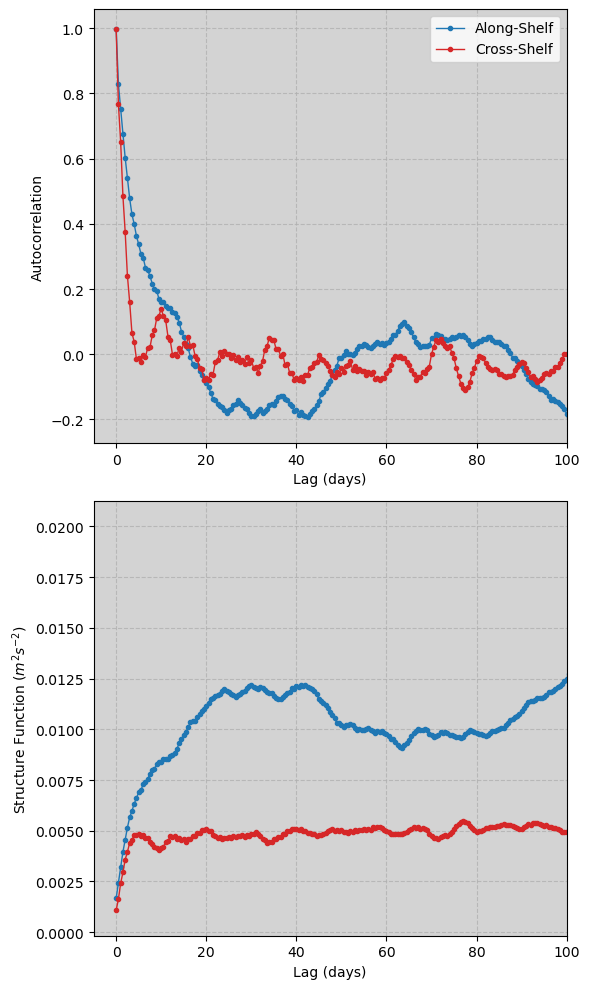

In [15]:
# Convert time scale to months
time_scale_days = time_scale_ud*(1/60)*(1/60)*(1/24)
lag_days = lag_ud*(1/60)*(1/60)*(1/24)

# Create the figure
fig = plt.figure(figsize=(6, 10))

#--- Subplot 1 ---# 
ax = fig.add_subplot(211)

# Plot the Autocorrelation Function
ax.plot(time_scale_days, autocorr_ud , '.-', color='tab:blue', linewidth=1,label='Along-Shelf')
ax.plot(time_scale_days, autocorr_vd , '.-', color='tab:red', linewidth=1,label='Cross-Shelf')

# Set figure attributes
ax.set_xlabel(r'Lag (days)')
ax.set_ylabel(r'Autocorrelation')
ax.set_xlim([-5,100])
ax.grid(True,linestyle='--',alpha=0.8)
ax.legend()

# Set the background color of the axes
ax.set_facecolor('lightgray')

#--- Subplot 2 ---# 
ax = fig.add_subplot(212)

# Plot the Structure Function
ax.plot(time_scale_days, struct_ud[2], '.-', color='tab:blue', linewidth=1)
ax.plot(time_scale_days, struct_vd[2], '.-', color='tab:red', linewidth=1)

# Set figure attributes
ax.set_xlabel(r'Lag (days)')
ax.set_ylabel(r'Structure Function ($m^2 s^{-2}$)')
ax.set_xlim([-5,100])
ax.grid(True,linestyle='--',alpha=0.8)

# Set the background color of the axes
ax.set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_51340/2759593514.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


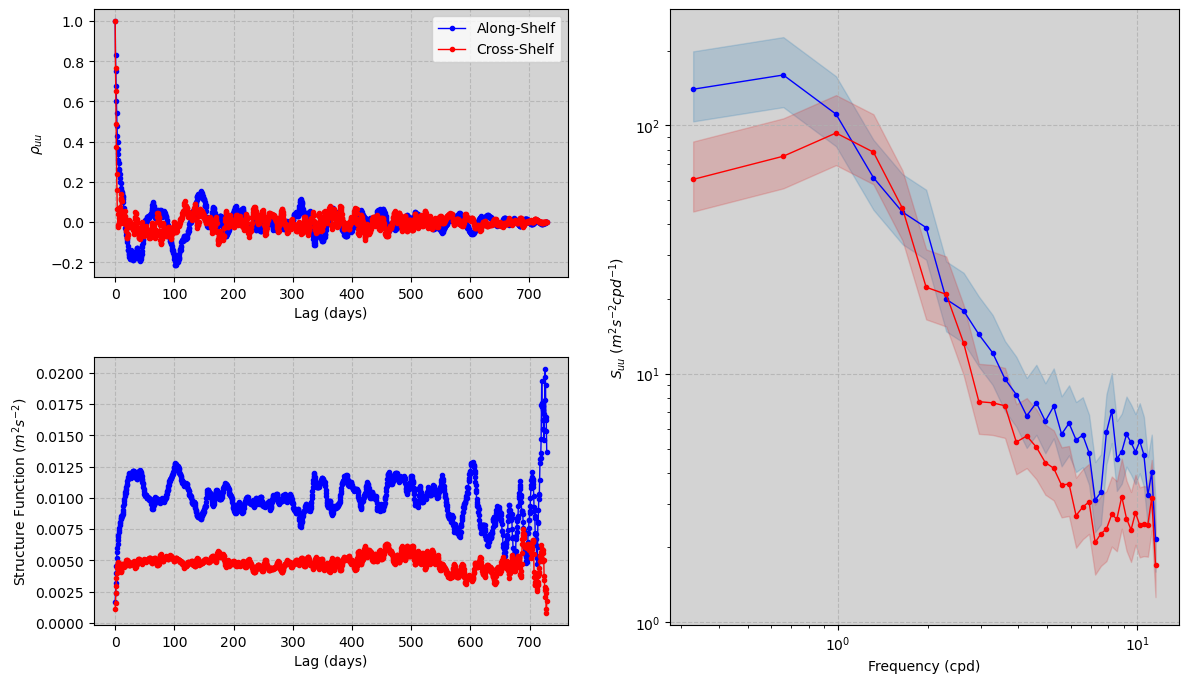

In [16]:
# Convert time scale to days
time_scale_days = time_scale_ud * (1 / 60) * (1 / 60) * (1 / 24)
lag_days = lag_ud * (1 / 60) * (1 / 60) * (1 / 24)

# Create the figure with taller aspect ratio
fig = plt.figure(figsize=(14, 8))  # wider to help spectrum breathing room

# Define custom GridSpec layout
gs = gridspec.GridSpec(2, 3, width_ratios=[1.4, 0.1, 1.5], height_ratios=[1, 1], wspace=0.1, hspace=0.3)

#--- Autocorrelation Function (Top-Left) ---#
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(time_scale_days, autocorr_ud, '.-', color='blue', linewidth=1, label='Along-Shelf')
ax1.plot(time_scale_days, autocorr_vd, '.-', color='red', linewidth=1, label='Cross-Shelf')
ax1.set_xlabel(r'Lag (days)')
ax1.set_ylabel(r'$\rho_{uu}$')
ax1.grid(True, linestyle='--', alpha=0.8)
ax1.legend()
ax1.set_facecolor('lightgray')

#--- Structure Function (Bottom-Left) ---#
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(time_scale_days, struct_ud[2], '.-', color='blue', linewidth=1)
ax2.plot(time_scale_days, struct_vd[2], '.-', color='red', linewidth=1)
ax2.set_xlabel(r'Lag (days)')
ax2.set_ylabel(r'Structure Function ($m^2 s^{-2}$)')
ax2.grid(True, linestyle='--', alpha=0.8)
ax2.set_facecolor('lightgray')

#--- Power Spectrum (Right, spanning both rows) ---#
ax3 = fig.add_subplot(gs[:, 2])
ax3.loglog(f_cpd[1:], S_ud[1:], '.-', color='blue', linewidth=1)
ax3.loglog(f_cpd[1:], S_vd[1:], '.-', color='red', linewidth=1)
ax3.fill_between(f_cpd[1:], CI_ud[1:, 0], CI_ud[1:, 1], color='tab:blue', alpha=0.2)
ax3.fill_between(f_cpd[1:], CI_vd[1:, 0], CI_vd[1:, 1], color='tab:red', alpha=0.2)
ax3.set_xlabel(r'Frequency (cpd)')
ax3.set_ylabel(r'$S_{uu}$ ($m^2 s^{-2} cpd^{-1}$)')
ax3.grid(True, linestyle='--', alpha=0.8)
ax3.set_facecolor('lightgray')

# Final layout
plt.tight_layout()
plt.show()


Compute the tidal and interial frequencies

In [25]:
# Tidal constituents and their frequencies (cycles per day)
T_m2 = 12.42 * (1/24)           # Units: days
T_k1 = 23.93 * (1/24)           # Units: days
T_s2 = 12.00 * (1/24)           # Units: days
tidal_constituents = {
    r'$M2$': 1 / T_m2, 
    r'$K1$': 1 / T_k1,  
    r'$S2$': 1 / T_s2,  
}

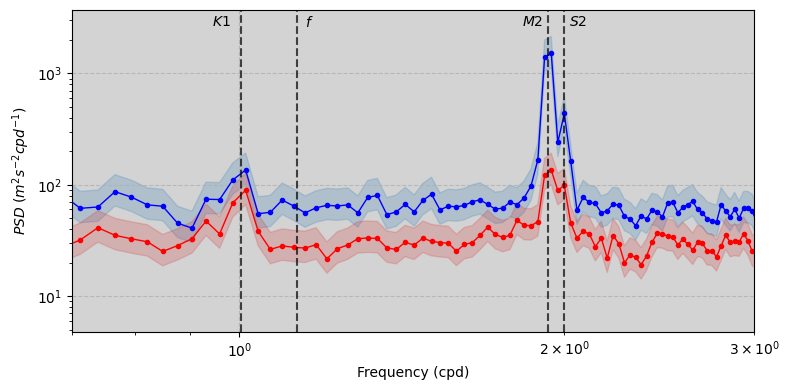

In [29]:
# Create the figure with taller aspect ratio
fig, ax = plt.subplots(1,1,figsize=(8, 4))

# Plot power spectrum 
ax.loglog(f_cpd[1:], S_ud[1:], '.-', color='blue', linewidth=1)
ax.loglog(f_cpd[1:], S_vd[1:], '.-', color='red', linewidth=1)
ax.fill_between(f_cpd[1:], CI_ud[1:, 0], CI_ud[1:, 1], color='tab:blue', alpha=0.2)
ax.fill_between(f_cpd[1:], CI_vd[1:, 0], CI_vd[1:, 1], color='tab:red', alpha=0.2)

# Plot inertial frequency
ax.axvline(f_inertial, color='k', linestyle='--', alpha=0.7)
ax.text(f_inertial+0.02, plt.ylim()[1]*0.78, r'$f$', rotation=0, verticalalignment='center', horizontalalignment='left', color='k', alpha=1, fontsize=10)

# Initialize counter
cn = 0 

# Loop through tidal constituents
for name, freq in tidal_constituents.items():

    # Plot tidal constituent lines and text
    if cn < 2:
        ax.axvline(freq, color='k', linestyle='--', alpha=0.7)
        ax.text(freq-0.02, plt.ylim()[1]*0.78, name, rotation=0, verticalalignment='center', horizontalalignment='right', color='k', alpha=1, fontsize=10)
    else: 
        ax.axvline(freq, color='k', linestyle='--', alpha=0.7)
        ax.text(freq+0.02, plt.ylim()[1]*0.78, name, rotation=0, verticalalignment='center', horizontalalignment='left', color='k', alpha=1, fontsize=10)

    # Reinitialize counter
    cn += 1

# Set figure attributes
ax.set_xlabel(r'Frequency (cpd)')
ax.set_ylabel(r'$PSD$ ($m^2 s^{-2} cpd^{-1}$)')
ax.grid(True, linestyle='--', alpha=0.8)
ax.set_facecolor('lightgray')
ax.set_xlim([7*10**(-1),  3*10**(-0)])

# Final layout
plt.tight_layout()
plt.show()

In [32]:
time_bin_dt

array([datetime.datetime(2014, 1, 1, 6, 0),
       datetime.datetime(2014, 1, 1, 18, 0),
       datetime.datetime(2014, 1, 2, 6, 0), ...,
       datetime.datetime(2015, 12, 30, 18, 0),
       datetime.datetime(2015, 12, 31, 6, 0),
       datetime.datetime(2015, 12, 31, 18, 0)], dtype=object)

In [34]:
# Identify unique (year, month) pairs
months = np.array([(t.year, t.month) for t in time_bin_dt])
unique_months = np.unique(months, axis=0)

# Dictionaries to hold results
Lt_ud_monthly = {}
Lt_vd_monthly = {}

# Loop through months
for year, month in unique_months:

    # Find indices for the current month
    month_mask = ((months[:,0] == year) & (months[:,1] == month))

    # Subset data
    time_n = time_bin[month_mask]
    U_month = U_shelf_depth_bin[month_mask]
    V_month = V_shelf_depth_bin[month_mask]

    # Skip if not enough data
    if len(time_n) < 10 or np.ma.is_masked(U_month) and U_month.mask.all():
        continue

    # Remove seasonal cycle
    hfit_u, *_ = unweighted_lsf(U_month, time_n, parameters=2, freqs=np.array([w1, w2]), sigma=None)
    data_u_rm = U_month - hfit_u
    data_u_dt = detrend(data_u_rm, time_n, mean=0)

    hfit_v, *_ = unweighted_lsf(V_month, time_n, parameters=2, freqs=np.array([w1, w2]), sigma=None)
    data_v_rm = V_month - hfit_v
    data_v_dt = detrend(data_v_rm, time_n, mean=0)

    # Autocorrelation
    lag = len(time_n)
    autocorr_ud, _, _, _, time_scale_ud, _ = compute_autocorr_optimize(data_u_dt, time_n, lag, estimator, 0)
    autocorr_vd, _, _, _, time_scale_vd, _ = compute_autocorr_optimize(data_v_dt, time_n, lag, estimator, 0)

    # De-correlation scale
    L_t_ud = compute_decor_scale_optimize(autocorr_ud, time_scale_ud, T, 'unbiased', 0)
    L_t_vd = compute_decor_scale_optimize(autocorr_vd, time_scale_vd, T, 'unbiased', 0)

    # Convert to days
    Lt_ud_monthly[(year, month)] = L_t_ud / (60*60*24)
    Lt_vd_monthly[(year, month)] = L_t_vd / (60*60*24)


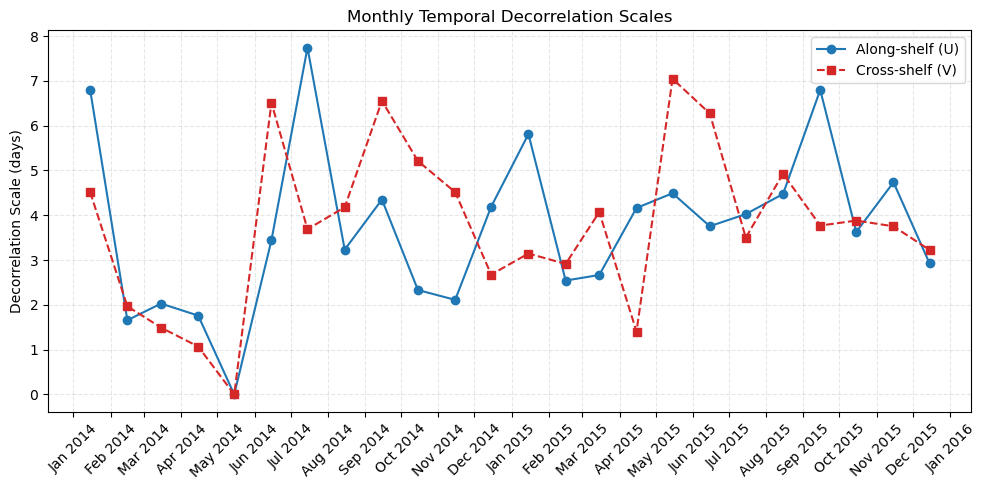

In [43]:
# Convert dictionary to sorted lists of datetime objects and values
months_sorted = sorted(Lt_ud_monthly.keys())  # e.g., [(2023, 1), (2023, 2), ...]
dates = [datetime(year, month, 15) for (year, month) in months_sorted]  # Use mid-month for clarity

Lt_ud_values = [Lt_ud_monthly[(year, month)] for (year, month) in months_sorted]
Lt_vd_values = [Lt_vd_monthly[(year, month)] for (year, month) in months_sorted]

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(dates, Lt_ud_values, marker='o', label='Along-shelf (U)', linestyle='-', color='tab:blue')
ax.plot(dates, Lt_vd_values, marker='s', label='Cross-shelf (V)', linestyle='--', color='tab:red')

# Formatting
ax.set_title('Monthly Temporal Decorrelation Scales')
ax.set_ylabel('Decorrelation Scale (days)')
#ax.set_xlabel('Time')
ax.legend()
ax.grid(True,linestyle='--',alpha=0.3)

# Format x-axis to show months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [45]:
np.shape(EKE_depth_bin)

(1460,)

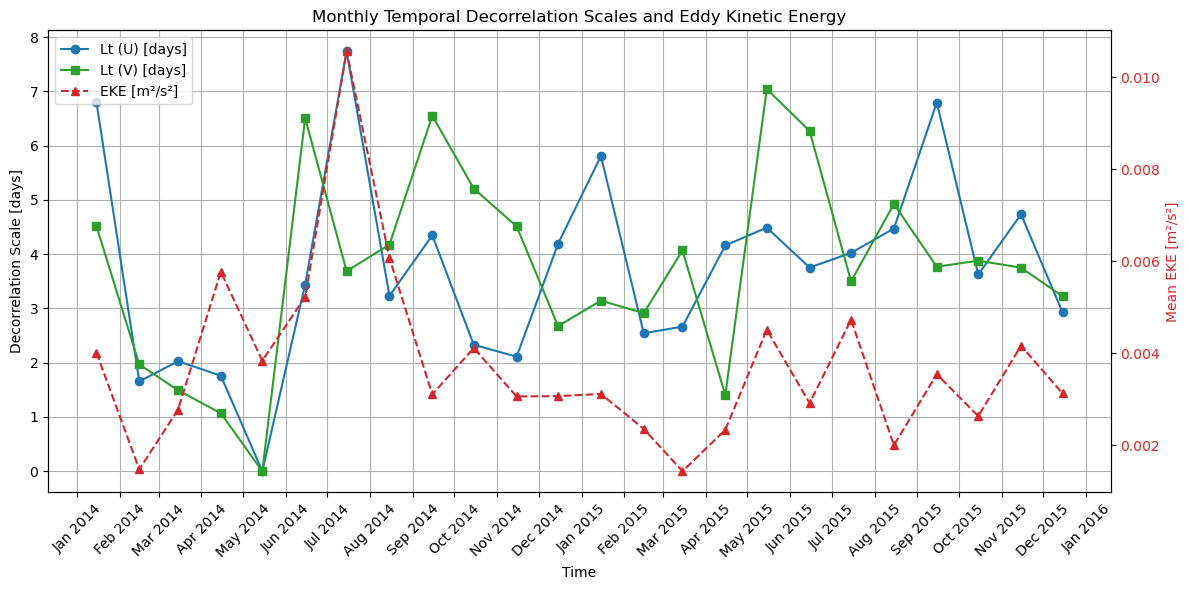

In [46]:
#------------------------------------------------------------#
# Compute monthly mean EKE
#------------------------------------------------------------#

# Extract (year, month) from each time point
months_eke = np.array([(t.year, t.month) for t in time_bin_dt])
unique_months = np.unique(months_eke, axis=0)

# Set dictionary
EKE_monthly_mean = {}

# Loop through months and years
for year, month in unique_months:

    # Find indices for the current month
    mask = (months_eke[:, 0] == year) & (months_eke[:, 1] == month)

    # Subset data
    EKE_month = EKE_depth_bin[mask]

    # Skip if not enough data
    if len(EKE_month) == 0 or (np.ma.is_masked(EKE_month) and EKE_month.mask.all()):
        continue

    # Compute monthly mean
    EKE_monthly_mean[(year, month)] = np.nanmean(EKE_month)

#------------------------------------------------------------#
# Prepare data for plotting
#------------------------------------------------------------#

# Get all months that exist in both datasets
common_months = sorted(set(Lt_ud_monthly) & set(Lt_vd_monthly) & set(EKE_monthly_mean))

dates = [datetime(year, month, 15) for (year, month) in common_months]
Lt_ud = [Lt_ud_monthly[(y, m)] for (y, m) in common_months]
Lt_vd = [Lt_vd_monthly[(y, m)] for (y, m) in common_months]
EKE_means = [EKE_monthly_mean[(y, m)] for (y, m) in common_months]

#------------------------------------------------------------#
# Plot decorrelation scales + EKE on one figure
#------------------------------------------------------------#

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot U and V decorrelation scales (left y-axis)
ax1.plot(dates, Lt_ud, label='Lt (U) [days]', color='tab:blue', marker='o')
ax1.plot(dates, Lt_vd, label='Lt (V) [days]', color='tab:green', marker='s')
ax1.set_ylabel('Decorrelation Scale [days]', color='black')
ax1.set_xlabel('Time')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

# Format x-axis for months
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

# Twin y-axis for EKE
ax2 = ax1.twinx()
ax2.plot(dates, EKE_means, label='EKE [m²/s²]', color='tab:red', marker='^', linestyle='--')
ax2.set_ylabel('Mean EKE [m²/s²]', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Monthly Temporal Decorrelation Scales and Eddy Kinetic Energy')
plt.tight_layout()
plt.show()
